<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Ханбикова Элина

**Забавный факт о себе:**

## Общая информация

__Дата выдачи:__ 09.12.2023

__Дедлайн:__ 23:59MSK 18.12.2023

В случае этой домашки мягкий дедлан совпадает с жёстким.

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 5.2 балла (3 основных балла и ещё 2.2 бонусных).

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [3]:
import gdown

url = "https://drive.google.com/drive/folders/1SoRp5xoOo9lJySnQHvkCPoGFl9AXwq0T?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/news_data/ria_news.tsv',
 '/content/news_data/vk_comments.tsv',
 '/content/news_data/vk_news.tsv']

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [4]:
df_ria = pd.read_csv("news_data/ria_news.tsv", sep="\t")
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [5]:
df_vk = pd.read_csv("news_data/vk_news.tsv", sep="\t")
df_vk["snippet"] = df_vk["text"]
df_vk.drop("text", axis=1, inplace=True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [6]:
df_comments = pd.read_csv("news_data/vk_comments.tsv", sep="\t")
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

<ipython-input-6-f69889390bb6>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv("news_data/vk_comments.tsv", sep="\t")


(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Вы обучите нейросеть предсказывать категорию новости
2. Вы построите предсказания для тех новостей, где мы ничего не знаем о категории
3. Вы используете уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Вы проведёте аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (1.2 + 2 бонусных балла)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [7]:
from collections import Counter

# удалим все лишние пробелы и сделаем lowercase
df_ria["tags"] = df_ria.tags.apply(
    lambda w: ",".join([item.strip() for item in w.lower().split(",")])
)

tags = ",".join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(","))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [8]:
target_tags = {tag for tag, cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

Закодируем теги для OHE.

In [9]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item, jtem in tag2idx.items()}

Почистим таргет от лишних тэгов.

In [10]:
df_ria["target_tags"] = df_ria.tags.apply(
    lambda w: [tag2idx.get(item) for item in w.split(",") if item in target_tags]
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [11]:
df_ria.target_tags.values[:3]

array([list([1342, 626, 376]), list([1345, 1505, 376]), list([1337])],
      dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к маленькому регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [12]:
import nltk

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
import re
from nltk.tokenize import word_tokenize

TAGS = re.compile("<.*?>")


def normalise_text(text):
    text = re.sub(TAGS, "", text)
    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub("[^а-яa-z0-9 ]", "", text)
    return text.strip()


df_ria["title_clean"] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(" ".join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [14]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [15]:
from nltk.corpus import stopwords

stops_ru = set(stopwords.words("russian"))
len(stops_ru)

151

In [16]:
vocabulary = {"#PAD#": 0, "#UNK#": 1}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [17]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [18]:
def create_vocab(text, stops_ru=stops_ru):
    word_cnt = Counter(word_tokenize(text))
    vocabulary = {"#PAD#": 0, "#UNK#": 1}

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

__[0.2 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [19]:
df_vk["title_clean"] = df_vk.title.apply(normalise_text)

In [20]:
vk_vocab = create_vocab(" ".join(df_vk.title_clean.values))

In [21]:
def normalise_snippet(snippet):
    if pd.notnull(snippet):
        return normalise_text(snippet)
    return "#UNK#"

In [22]:
df_ria["snippet_clean"] = df_ria.snippet.apply(normalise_snippet)

In [23]:
df_vk["snippet_clean"] = df_vk.snippet.apply(normalise_snippet)

## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [24]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = vk_hrefs & ria_hrefs

print("Размер отложенной выборки:", len(test_hrefs))

df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [25]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[
    df_ria.href.isin(test_hrefs)
].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

__[0.2 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [26]:
df_test = df[(df["date"] >= "2018-12-01") & (df["date"] <= "2018-12-31")]
df_val = df[(df["date"] >= "2018-10-01") & (df["date"] <= "2018-11-30")]
df_train = df[df["date"] < "2018-10-01"]

Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [27]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][["href", "title_clean"]]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][["href", "target_tags"]]
df_oob = df_oob.set_index("href").join(df_ria_oob.set_index("href")).reset_index()
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[1353, 1080]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[215, 376]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[826, 305]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[1217]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[65, 376]"


Напишем датасет для поставки данных в нейросеть.


In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class NewsDataset(Dataset):
    def __init__(
        self,
        target,
        title,
        vocab,
        vocab_size,
        max_title_len,
        max_classes,
        snippet=None,
        max_snippet_len=None,
    ):
        self.vocab = {word: idx for word, idx in vocab.items() if idx < vocab_size}
        self.max_classes = max_classes
        self.y = self.target_ohe(target)
        self.X_title = self.create_text(title, max_title_len)

        self.snippet_included = snippet is not None
        if self.snippet_included:
            self.X_snippet = self.create_text(snippet, max_snippet_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i] * len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = []
        for sent in texts:
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        if self.snippet_included:
            return (self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx])
        else:
            return (self.X_title[idx, :], self.y[idx])

__[0.2 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# Внесите в код датасета выше свои правки

Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [ ]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 15

# словарь создаем по всей выборке
vocabulary = create_vocab(" ".join(df_ria.title_clean.values))

# объявляем датасеты
train_dataset = NewsDataset(
    df_train.target_tags.values,
    df_train.title_clean.values,
    vocabulary,
    VOCAB_SIZE,
    MAX_TITLE_LEN,
    CLASSES_NUM,
)
val_dataset = NewsDataset(
    df_val.target_tags.values,
    df_val.title_clean.values,
    vocabulary,
    VOCAB_SIZE,
    MAX_TITLE_LEN,
    CLASSES_NUM,
)
test_dataset = NewsDataset(
    df_test.target_tags.values,
    df_test.title_clean.values,
    vocabulary,
    VOCAB_SIZE,
    MAX_TITLE_LEN,
    CLASSES_NUM,
)

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=32, num_workers=4)

## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [ ]:
from torch import nn
import torch.nn.functional as F


class SimpleClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title).mean(dim=1)
        return self.fc(embedded)

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [ ]:
!pip3 install pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 34.0 MB/s eta 0:00:00


Обучим модель.

In [ ]:
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
import wandb
from pytorch_lightning.loggers import WandbLogger

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import pytorch_lightning as pl


class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title):
        result = self.model(title)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        if len(train_batch) == 2:
            title, target = train_batch
            logits = self.model(title)
        else:
            title, snippet, target = train_batch
            logits = self.model(title, snippet)

        loss = self.criterion(logits, target)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        if len(val_batch) == 2:
            title, target = val_batch
            logits = self.model(title)
        else:
            title, snippet, target = val_batch
            logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log("val_loss", loss)
        return loss

In [ ]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module = TrainLightningModule(model_baseline, LR, criterion)

wandb_logger = WandbLogger(name="SimpleClassifier", project="hw4")
trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: mbublik. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimpleClassifier | 3.5 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.906    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,▇█▇▄▆▃▃▄▃▂▃▃▃▃▄▂▂▂▁▂▂▁▂▄▃▃▃▂▂▃▂▁▂▂▃▂▁▂▁▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁
epoch,4
train_loss,5.64985
trainer/global_step,21389
val_loss,10.9198


__[0.2 балла] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

In [ ]:
from torch import nn


class SnippetClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(600, output_dim)

    def forward(self, title, snippet):
        embedded_title = self.embedding(title).mean(dim=1)
        embedded_snippet = self.embedding(snippet).mean(dim=1)

        concatenated = torch.cat((embedded_title, embedded_snippet), dim=1)

        return self.fc(concatenated)

In [ ]:
MAX_SNIPPET_LEN = 200

train_dataset_snippet = NewsDataset(
    df_train.target_tags.values,
    df_train.title_clean.values,
    vocabulary,
    VOCAB_SIZE,
    MAX_TITLE_LEN,
    CLASSES_NUM,
    df_train.snippet_clean.values,
    MAX_SNIPPET_LEN,
)
val_dataset_snippet = NewsDataset(
    df_val.target_tags.values,
    df_val.title_clean.values,
    vocabulary,
    VOCAB_SIZE,
    MAX_TITLE_LEN,
    CLASSES_NUM,
    df_val.snippet_clean.values,
    MAX_SNIPPET_LEN,
)
test_dataset_snippet = NewsDataset(
    df_test.target_tags.values,
    df_test.title_clean.values,
    vocabulary,
    VOCAB_SIZE,
    MAX_TITLE_LEN,
    CLASSES_NUM,
    df_test.snippet_clean.values,
    MAX_SNIPPET_LEN,
)

In [ ]:
train_dataloader_snippet = DataLoader(
    train_dataset_snippet, shuffle=True, batch_size=32, num_workers=4
)
val_dataloader_snippet = DataLoader(
    val_dataset_snippet, shuffle=False, batch_size=32, num_workers=4
)

In [ ]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_snippets = SnippetClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module = TrainLightningModule(model_snippets, LR, criterion)

wandb_logger = WandbLogger(name="SnippetClassifier", project="hw4")
trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader_snippet, val_dataloader_snippet)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | SnippetClassifier | 4.0 M 
1 | criterion | CrossEntropyLoss  | 0     
------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.806    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,█▇▇▅▅▄▄▄▄▃▃▃▃▂▃▃▄▃▃▄▃▃▂▃▂▂▂▂▂▃▃▂▂▁▃▃▃▃▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▁▁▁
epoch,4
train_loss,4.80275
trainer/global_step,21389
val_loss,10.63315


# [Дашборд](https://wandb.ai/mbublik/hw4/table?workspace=user-mbublik)

На валидационной выборке новая модель лишь немного обгоняет старую, показывая чуть меньшие значения loss.

In [ ]:
import gc


def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
clear_cache()

## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [ ]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num / (denum + 1e-5)).mean().item()


def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num / (denum + 1e-5)).mean().item()


def exact_match(target, y_pred):
    return (1.0 * (y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [ ]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=32)

all_pred_probs = []
all_targets = []

model_baseline.eval()
model_snippets.eval()

with torch.no_grad():
    for title, target in test_dataloader:
        logit = model_baseline(title)
        pred_prob = F.softmax(logit, dim=1)

        all_pred_probs.append(pred_prob)
        all_targets.append(target)

final_pred_probs = torch.cat(all_pred_probs, dim=0)
final_targets = torch.cat(all_targets, dim=0)

assert final_pred_probs.shape[0] == len(test_dataset)
assert final_targets.shape[0] == len(test_dataset)

In [ ]:
target, pred_prob = final_targets, final_pred_probs

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [ ]:
TRESHOLD = 0.01
y_pred = 1 * (pred_prob > TRESHOLD)

print("Exact Match:", exact_match(target, y_pred))
print("Precision:", precision(target, y_pred))
print("Recall:", recall(target, y_pred))

Exact Match: 0.995667040348053
Precision: 0.304833322763443
Recall: 0.77463299036026


In [ ]:
TRESHOLD = 0.05
y_pred = 1 * (pred_prob > TRESHOLD)
print("Exact Match:", exact_match(target, y_pred))
print("Precision:", precision(target, y_pred))
print("Recall:", recall(target, y_pred))

Exact Match: 0.9982913732528687
Precision: 0.5201880931854248
Recall: 0.6403709650039673


In [ ]:
TRESHOLD = 0.9
y_pred = 1 * (pred_prob > TRESHOLD)

print("Exact Match:", exact_match(target, y_pred))
print("Precision:", precision(target, y_pred))
print("Recall:", recall(target, y_pred))

Exact Match: 0.9983203411102295
Precision: 0.009615288116037846
Recall: 0.008004485629498959


Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

In [ ]:
def get_predict(model, dataloader, snippet=False, batch_size=32):
    all_pred_probs = []
    all_targets = []

    with torch.no_grad():
        if snippet:
            for title, snippet, target in dataloader:
                logit = model(title, snippet)
                pred_prob = F.softmax(logit, dim=1)
                all_pred_probs.append(pred_prob)
                all_targets.append(target)
        else:
            for title, target in dataloader:
                logit = model(title)
                pred_prob = F.softmax(logit, dim=1)
                all_pred_probs.append(pred_prob)
                all_targets.append(target)

    final_pred_probs = torch.cat(all_pred_probs, dim=0)
    final_targets = torch.cat(all_targets, dim=0)

    return final_pred_probs, final_targets

__[0.2 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__ Более релевантной метрикой является полнота, поскольку ошибка в этой задаче очень дорогая, и нам важна корректность предсказанных тегов.

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [ ]:
def find_optimal_threshold(model, dataloader):
    pred_prob, target = get_predict(model, dataloader)

    stats = {}

    for t in [*list(range(1, 20))]:
        threshold = t * 0.01
        y_pred = 1 * (pred_prob > threshold)
        stats[t] = precision(target, y_pred)

    best_t = max(stats, key=stats.get)
    return best_t * 0.01, stats[best_t]

In [ ]:
best_threshold, best_precision = find_optimal_threshold(model_baseline, val_dataloader)
print(f"Best Threshold: {best_threshold}, Best Precision: {best_precision}")

Best Threshold: 0.14, Best Precision: 0.7311519980430603


In [ ]:
pred_prob, target = get_predict(model_baseline, test_dataloader)
y_pred = 1 * (pred_prob > best_threshold)
print("Precision (baseline):", precision(target, y_pred))

Precision (baseline): 0.5885769128799438


In [ ]:
test_dataloader_snippet = DataLoader(test_dataset_snippet, shuffle=False, batch_size=32)

In [ ]:
pred_prob, target = get_predict(model_snippets, test_dataloader_snippet, snippet=True)
y_pred = 1 * (pred_prob > best_threshold)
print("Precision (with snippets):", precision(target, y_pred))

Precision (with snippets): 0.5562760233879089


Модель без сниппетов оказалась чуть лучше.

__[0.2 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [ ]:
df_oob.head()

,href,title_clean,target_tags
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,"[539, 750]"
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,"[8, 1202]"
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,"[673, 1050]"
3,/20181206/1547521406.html,школа в красноярске превратилась в хогвартс из...,[104]
4,/20181206/1547522342.html,рада решила не продлевать договор о дружбе и с...,"[1555, 1202]"


In [ ]:
oob_dataset = NewsDataset(
    df_oob.target_tags.values,
    df_oob.title_clean.values,
    vocabulary,
    VOCAB_SIZE,
    MAX_TITLE_LEN,
    CLASSES_NUM,
)

oob_dataloader = DataLoader(oob_dataset, shuffle=False, batch_size=32)

In [ ]:
pred_prob, target = get_predict(model_baseline, oob_dataloader)
y_pred = 1 * (pred_prob > best_threshold)
print("Precision (no snippets, OOB):", precision(target, y_pred))

Precision (no snippets, OOB): 0.5711200833320618


Качество модели не изменилось в пределах погрешности.

## 1.6 Бонусное задание

Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.5 балла]__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.   

__Ваш лог экспериментов:__


Добавим сверточных слоев с ReLU, max_pooling, и dropout.

Мы получаем более высокий validation loss, чем на базовой архитектуре, который еще и растет с каждой эпохой. Давайте сделаем dropout побольше, поменяем параметры свертки и добавим batch-нормализацию.

Validation loss больше не растет, однако, модель все равно показывает результаты хуже. Используем оптимизатор RMSProp.

К сожалению, мы не смогли добиться результата лучше, чем у базовой модели: сложность нашей архитектуры отрицательно влияет на валидационную метрику.

In [ ]:
import torch.nn.functional as F

In [ ]:
class SuperPuperMegaImprovedClassifier9001(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()

        n_filters = 100
        filter_sizes = [2, 3, 4]
        dropout = 0.4

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.convs = nn.ModuleList(
            [
                nn.Conv1d(
                    in_channels=embedding_dim, out_channels=n_filters, kernel_size=fs
                )
                for fs in filter_sizes
            ]
        )

        self.batch_norms = nn.ModuleList(
            [nn.BatchNorm1d(n_filters) for _ in filter_sizes]
        )

        self.fc = nn.Linear(len(filter_sizes) * n_filters * 2, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, title, snippet):
        embedded_title = self.embedding(title).permute(0, 2, 1)
        embedded_snippet = self.embedding(snippet).permute(0, 2, 1)

        convoluted_title = [
            F.relu(self.batch_norms[i](conv(embedded_title)))
            for i, conv in enumerate(self.convs)
        ]
        convoluted_snippet = [
            F.relu(self.batch_norms[i](conv(embedded_snippet)))
            for i, conv in enumerate(self.convs)
        ]

        pooled_title = [
            F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in convoluted_title
        ]
        pooled_snippet = [
            F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in convoluted_snippet
        ]

        concatenated = torch.cat(pooled_title + pooled_snippet, dim=1)

        dropped = self.dropout(concatenated)

        return self.fc(dropped)

In [ ]:
from torch.optim.lr_scheduler import StepLR


class BestestUltraImprovedTrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate

    def forward(self, title):
        result = self.model(title)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        if len(train_batch) == 2:
            title, target = train_batch
            logits = self.model(title)
        else:
            title, snippet, target = train_batch
            logits = self.model(title, snippet)

        loss = self.criterion(logits, target)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        if len(val_batch) == 2:
            title, target = val_batch
            logits = self.model(title)
        else:
            title, snippet, target = val_batch
            logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log("val_loss", loss)
        return loss

In [ ]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_improved = SuperPuperMegaImprovedClassifier9001(
    VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM
)
criterion = torch.nn.CrossEntropyLoss()

train_module = BestestUltraImprovedTrainLightningModule(model_improved, LR, criterion)

wandb_logger = WandbLogger(name="SuperPuperMegaImprovedClassifier9002", project="hw4")
trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader_snippet, val_dataloader_snippet)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                                 | Params
-------------------------------------------------------------------
0 | model     | SuperPuperMegaImprovedClassifier9001 | 4.2 M 
1 | criterion | CrossEntropyLoss                     | 0     
-------------------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.889    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,██▇▅▅▃▅▄▄▆▃▄▅▁▄▂▃▂▃▂▁▂▂▂▄▃▄▅▂▂▄▄▄▂▂▅▄▃▃▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▂▁▂
epoch,4
train_loss,8.8998
trainer/global_step,21389
val_loss,12.28941


__[0.5]__ Скачайте с сайта [Rusvectores](https://rusvectores.org/ru/models/) любые новостные word2vec эмбединги. Возьмите из модели эмбеддинги для всех слов, которые встречаются вв вашем словаре и добавьте их в модель первым слоем. Заморозьте этот слой и не обновляйте в нём веса. Если у вас в словаре есть слово, но его нет среди предобученных эмбеддингов, замените его на токен `#UNKN`.

In [ ]:
!wget http://vectors.nlpl.eu/repository/20/184.zip
!unzip 184.zip

--2023-12-17 09:35:47--  http://vectors.nlpl.eu/repository/20/184.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640196018 (611M) [application/zip]
Saving to: ‘184.zip’

184.zip             100%[===================>] 610.54M  22.6MB/s    in 28s     

2023-12-17 09:36:16 (22.0 MB/s) - ‘184.zip’ saved [640196018/640196018]

Archive:  184.zip
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  


__Ваш лог экспериментов:__

Модель ведет себя чуть хуже по сравнению с обычной, но после 5 эпохи сравнивается с моделью со сниппетами.

In [ ]:
import gensim

embeddings = gensim.models.KeyedVectors.load_word2vec_format("model.bin", binary=True)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
unk_embedding = unk_vector = np.mean(embeddings.vectors, axis=0)

for i, word in enumerate(vocabulary):
    if i >= VOCAB_SIZE:
        break
    if word in embeddings:
        embedding_matrix[i] = embeddings[word]
    else:
        embedding_matrix[i] = torch.zeros(EMBEDDING_DIM)

In [ ]:
class SimpleClassifierEmbeddings(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pretrained_embeddings):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(
            torch.tensor(pretrained_embeddings, dtype=torch.float32)
        )
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title).mean(dim=1)
        return self.fc(embedded)

In [ ]:
model_baseline_embeddings = SimpleClassifierEmbeddings(
    VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM, embedding_matrix
)
for param in model_baseline.embedding.parameters():
    param.requires_grad = False

EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

criterion = torch.nn.CrossEntropyLoss()

train_module = TrainLightningModule(model_baseline_embeddings, LR, criterion)

wandb_logger = WandbLogger(name="SimpleClassifierEmbeddings", project="hw4")
trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, train_dataloader, val_dataloader)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                       | Params
---------------------------------------------------------
0 | model     | SimpleClassifierEmbeddings | 3.5 M 
1 | criterion | CrossEntropyLoss           | 0     
---------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.906    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,▆▇█▅▆▃▆▅▇▅▅▄▄▄▄▄▃▂▃▃▂▃▃▃▂▃▃▃▂▃▃▁▂▂▃▃▁▃▄▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▂▁▁
epoch,4
train_loss,6.45658
trainer/global_step,21389
val_loss,10.90982


__[1 балл]__ Зафайнтьюньте трансформер для решения задачи с помощью библиотеки `hugging face`. Выбор предобученной модели кратко обоснуйте.

__Ваш лог экспериментов:__

Было испытано две модели - DeepPavlov/rubert-base-cased и cointegrated/rubert-tiny2. Оптимизатор - AdamW, лосс - CrossEntropyLoss.

In [29]:
!pip install transformers[torch] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 7.2 MB/s eta 0:00:00


In [32]:
CLASSES_NUM = len(idx2tag)

In [31]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertForSequenceClassification
from torch.nn import BCEWithLogitsLoss
from torch.optim import AdamW


class NewsDatasetHF(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=15):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_len = max_len
        targets = self.data["target_tags"]
        one_hot = np.zeros((len(targets), CLASSES_NUM), dtype=int)
        for idx, tag_list in enumerate(targets):
            one_hot[idx, tag_list] = 1
        self.targets = torch.from_numpy(one_hot).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        title = self.data.iloc[idx]["title_clean"]
        targets = self.targets[idx]

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "labels": targets,
        }

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

train_dataset = NewsDatasetHF(df_train, tokenizer)
val_dataset = NewsDatasetHF(df_val, tokenizer)
test_dataset = NewsDatasetHF(df_test, tokenizer)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased",
    num_labels=CLASSES_NUM,
    problem_type="multi_label_classification",
)
model.config.label2id = tag2idx
model.config.id2label = idx2tag
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
from sklearn.metrics import precision_score, recall_score
import numpy as np
from tqdm import tqdm


def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model = model.train()
    losses = []
    precision_scores = []
    recall_scores = []

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        loss = loss_fn(logits, targets)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        predictions = torch.sigmoid(logits).detach().cpu().numpy()
        predictions = np.where(predictions > 0.5, 1, 0)

        batch_precision = precision_score(
            targets.detach().cpu().numpy(), predictions, average="samples"
        )
        batch_recall = recall_score(
            targets.detach().cpu().numpy(), predictions, average="samples"
        )

        precision_scores.append(batch_precision)
        recall_scores.append(batch_recall)

    return np.mean(losses), np.mean(precision_scores), np.mean(recall_scores)

In [ ]:
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()
    losses = []
    precision_scores = []
    recall_scores = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )

            logits = outputs.logits
            loss = loss_fn(logits, targets)
            losses.append(loss.item())

            predictions = torch.sigmoid(logits).detach().cpu().numpy()
            predictions = np.where(predictions > 0.5, 1, 0)

            batch_precision = precision_score(
                targets.detach().cpu().numpy(), predictions, average="samples"
            )
            batch_recall = recall_score(
                targets.detach().cpu().numpy(), predictions, average="samples"
            )

            precision_scores.append(batch_precision)
            recall_scores.append(batch_recall)

    return np.mean(losses), np.mean(precision_scores), np.mean(recall_scores)

In [ ]:
for epoch in range(3):
    print(f"Epoch {epoch + 1}/3")
    print("-" * 10)

    train_loss, train_precision, train_recall = train_epoch(
        model, train_loader, loss_fn, optimizer, device
    )
    print(f"Train loss {train_loss} precision {train_precision} recall {train_recall}")

    val_loss, val_precision, val_recall = eval_model(model, val_loader, loss_fn, device)
    print(f"Val loss {val_loss} precision {val_precision} recall {val_recall}")

Epoch 1/3
----------


100%|██████████| 2139/2139 [03:54<00:00,  9.12it/s]

Train loss 12.803932849131437 precision 0.012082494272502329 recall 0.9011943943728971


Val loss 11.794657705803594 precision 0.009822350179534717 recall 0.9223353925911041
Epoch 2/3
----------


100%|██████████| 2139/2139 [03:58<00:00,  8.97it/s]

Train loss 9.722498439416087 precision 0.00999095764070557 recall 0.9806207826582571


Val loss 10.626864322543849 precision 0.008428762082219316 recall 0.9472862036544333
Epoch 3/3
----------


100%|██████████| 2139/2139 [03:58<00:00,  8.95it/s]

Train loss 8.514639465426551 precision 0.008919581964286584 recall 0.9935794431787647


Val loss 10.063344065959637 precision 0.007711571028718377 recall 0.9572414114574476


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
model.save_pretrained("/content/drive/MyDrive/rubert-base-cased")

In [ ]:
print("rubert-base-cased")
model.eval()
test_loss, test_precision, test_recall = eval_model(model, test_loader, loss_fn, device)
print(f"Test Loss: {test_loss}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

rubert-base-cased
Test Loss: 9.864002319830883
Test Precision: 0.0066014539928111494
Test Recall: 0.9236410248400226


In [ ]:
tokenizer_tiny = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

train_dataset_tiny = NewsDatasetHF(df_train, tokenizer_tiny)
val_dataset_tiny = NewsDatasetHF(df_val, tokenizer_tiny)
test_dataset_tiny = NewsDatasetHF(df_test, tokenizer_tiny)

In [ ]:
model_tiny = BertForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2",
    num_labels=CLASSES_NUM,
    problem_type="multi_label_classification",
)
model_tiny.config.label2id = tag2idx
model_tiny.config.id2label = idx2tag
model_tiny.to(device)

train_loader_tiny = DataLoader(
    train_dataset_tiny, batch_size=32, shuffle=True, num_workers=4
)
val_loader_tiny = DataLoader(
    val_dataset_tiny, batch_size=32, shuffle=False, num_workers=4
)
test_loader_tiny = DataLoader(
    test_dataset_tiny, batch_size=32, shuffle=False, num_workers=4
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for epoch in range(3):
    print(f"Epoch {epoch + 1}/3")
    print("-" * 10)

    train_loss, train_precision, train_recall = train_epoch(
        model_tiny, train_loader_tiny, loss_fn, optimizer, device
    )
    print(f"Train loss {train_loss} precision {train_precision} recall {train_recall}")

    val_loss, val_precision, val_recall = eval_model(
        model_tiny, val_loader_tiny, loss_fn, device
    )
    print(f"Val loss {val_loss} precision {val_precision} recall {val_recall}")

Epoch 1/3
----------


100%|██████████| 4278/4278 [02:41<00:00, 26.50it/s]

Train loss 22.976586485867635 precision 0.0018657445026250227 recall 0.47025994501270596


Val loss 22.557754914436114 precision 0.001797676073011063 recall 0.4610850224674652
Epoch 2/3
----------


100%|██████████| 4278/4278 [02:40<00:00, 26.57it/s]

Train loss 22.976083794728012 precision 0.0018652986730165512 recall 0.46989398932321985


Val loss 22.557754914436114 precision 0.001797676073011063 recall 0.4610850224674652
Epoch 3/3
----------


100%|██████████| 4278/4278 [02:40<00:00, 26.68it/s]

Train loss 22.975908337825366 precision 0.0018628790306706 recall 0.4691992126093527


Val loss 22.557754914436114 precision 0.001797676073011063 recall 0.4610850224674652


In [ ]:
model_tiny.save_pretrained("/content/drive/MyDrive/rubert-tiny2")

Сравните все обученные модели между собой на тестовой выборке.

In [ ]:
print("rubert-tiny2")
model_tiny.eval()
test_loss, test_precision, test_recall = eval_model(
    model_tiny, test_loader_tiny, loss_fn, device
)
print(f"Test Loss: {test_loss}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

rubert-tiny2
Test Loss: 19.683042662268395
Test Precision: 0.0015281418237652433
Test Recall: 0.4484720842231024


Модель DeepPavlov сильно выигрывает по метрикам.

## Часть 2: предсказание категорий (0.3 балла)

Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [30]:
from transformers import AutoTokenizer, BertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [34]:
model = BertForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/rubert-base-cased",
    num_labels=CLASSES_NUM,
    problem_type="multi_label_classification",
)

In [36]:
model.device

device(type='cuda', index=0)

In [37]:
df_vk["target_tags"] = [[0]] * df_vk.shape[0]

vk_dataset = NewsDatasetHF(df_vk, tokenizer)

vk_loader = DataLoader(vk_dataset, batch_size=32, shuffle=True, num_workers=4)

In [38]:
def make_predictions(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            batch_predictions = torch.sigmoid(logits).cpu().numpy()
            predictions.extend(batch_predictions)

    return predictions

In [39]:
model_predictions = make_predictions(model, vk_loader, device)

threshold = 0.5
final_predictions = pd.DataFrame((np.array(model_predictions) > threshold).astype(int))
final_predictions

,0,1,2,3,4,5,6,7,8,9,...,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582
0,1,1,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,1,0,0
2,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
19924,0,1,1,0,0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0
19925,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
19926,0,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0


In [40]:
df_vk.head()

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#,[0]
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#,[0]
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#,[0]
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#,[0]
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,[0]


In [41]:
final_predictions["post_id"] = df_vk["id"]

In [ ]:
final_predictions.to_csv("/content/drive/MyDrive/final_predictions.csv")

На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

## Часть 3: сентимент-классификатор (0.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели?
Автор модели rubert-tiny2 - Давид Дале. Датасет для файн-тюнинга собран Сергеем Сметаниным. Файн-тюнингом занимался некий SL.
2. Как выглядит архитектура модели? Насколько модель большая?
Модель построена на основе BERT. Размер эмбеддингов - 312, слоев - 3. Модель очень маленькая по сравнению с остальными и предназначена для быстрой работы на небольших данных. К тому же, она использует веса от более больших моделей.
3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК?
Она обучена на большом корпусе текстов, как современных, так и старых. Она оптимизирована под небольшие предложения, поэтому для нашей задачи она вполне подходит.

Установим библиотеку. 🤗🤗🤗

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [ ]:
from transformers import pipeline

model_vk = pipeline(model="seara/rubert-tiny2-russian-sentiment", device=device)

Цикл для сентимент-анализа комментариев может работать довольно долго. Я крайне рекомендую вам переодически сохранять к себе на компьютер промежуточные результаты. Итоговый результат я рекомендую записать отдельным столбиком в таблицу с комментариями, а затем сохранить полученные результаты. 🤗🤗🤗

In [ ]:
df_vk.head(5)

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#


In [42]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


In [ ]:
df_comments.shape

(2612629, 5)

In [ ]:
for i in range(10):
    print(model_vk(df_comments.iloc[i]['text']))

[{'label': 'neutral', 'score': 0.9122462868690491}]
[{'label': 'neutral', 'score': 0.8793703317642212}]
[{'label': 'positive', 'score': 0.6762610077857971}]
[{'label': 'neutral', 'score': 0.9259392023086548}]
[{'label': 'neutral', 'score': 0.8662225008010864}]
[{'label': 'neutral', 'score': 0.8428512215614319}]
[{'label': 'neutral', 'score': 0.9245758056640625}]
[{'label': 'neutral', 'score': 0.9119594693183899}]
[{'label': 'neutral', 'score': 0.7873875498771667}]
[{'label': 'neutral', 'score': 0.88370281457901}]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [43]:
!gdown https://drive.google.com/uc?id=1yoc3rgJpiDI4p40o6A5CIjis3nI2WZc7

Downloading...
From: https://drive.google.com/uc?id=1yoc3rgJpiDI4p40o6A5CIjis3nI2WZc7
To: /content/df_sentiment.csv
100% 73.7M/73.7M [00:00<00:00, 325MB/s]


In [44]:
df_sentiment = pd.read_csv("df_sentiment.csv")
df_sentiment.head(5)

,label,score
0,neutral,0.912246
1,neutral,0.879370
2,positive,0.676261
3,neutral,0.925939
4,neutral,0.866223


In [45]:
df_comments_final = pd.concat([df_comments.reset_index(drop=True), df_sentiment.reset_index(drop=True)], axis=1)
df_comments_final.tail(20)

,id,post_id,datetime,text,likes,label,score
2612609,17989761,17976037.0,2017-09-30 05:42:49,"[id142882974|Сергей], ну конечно не будут. Буд...",0.0,negative,0.590214
2612610,17989762,17976037.0,2017-09-30 05:42:58,"[id415883695|Евгений], повторюсь я писал выше ...",0.0,neutral,0.851088
2612611,17989774,17976037.0,2017-09-30 05:44:28,"[id415883695|Евгений], у нас она добывается в ...",0.0,neutral,0.824206
2612612,17989776,17976037.0,2017-09-30 05:44:33,"[id142882974|Сергей], обучение длится пару мес...",0.0,neutral,0.868982
2612613,17989788,17976037.0,2017-09-30 05:46:35,"[id415883695|Евгений], и да поэтому саудиты ар...",0.0,neutral,0.767596
2612614,17989792,17976037.0,2017-09-30 05:46:46,"[id142882974|Сергей], в Сирии нефти меньше чем...",0.0,neutral,0.829413
2612615,17989809,17976037.0,2017-09-30 05:49:00,"[id415883695|Евгений], бред тогда во Франции б...",0.0,negative,0.612960
2612616,17989815,17976037.0,2017-09-30 05:50:00,"[id415883695|Евгений], и смотрите как если мал...",0.0,neutral,0.723061
2612617,17989822,17976037.0,2017-09-30 05:50:50,"[id142882974|Сергей], это говорит только о том...",0.0,negative,0.849679
2612618,17989832,17976037.0,2017-09-30 05:51:39,"[id142882974|Сергей], это газетная утка.",0.0,neutral,0.871363


## Часть 4: аналитика (1 балл + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.2 балла]__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [ ]:
df_comments_final['label'].value_counts(normalize=True)

neutral     0.699200
negative    0.228799
positive    0.072002
Name: label, dtype: float64

In [ ]:
top_comments = df_comments_final.sort_values(by='score').tail(10)
for _, txt in top_comments["text"].items():
    print(txt)

Отлично, просто отлично!
Я очень счастлива! Поздравляю!
Отлично! Здоровья всем желаю!
Отлично,люблю ездить в Эмираты
Отлично,молодцы
Отлично,я рад.
Отлично! 
Поздравляем!!!
отлично,молодцы!!!👍 респект
Отлично! Просто отлично! Молодцы! Поздравляю от души! Горжусь!
Отлично, молодец!Поздравляю!✨💫🌟💥


__[0.2 балла]__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [46]:
positive_comments = df_comments_final[df_comments_final['label'] == 'positive']
positive_counts = positive_comments.groupby('post_id').size()

negative_comments = df_comments_final[df_comments_final['label'] == 'negative']
negative_counts = negative_comments.groupby('post_id').size()

positive_counts_df = positive_counts.reset_index(name='positive_comments_count')
negative_counts_df = negative_counts.reset_index(name='negative_comments_count')

df_vk = df_vk.merge(positive_counts_df, how='left', left_on='id', right_on='post_id')
df_vk = df_vk.merge(negative_counts_df, how='left', left_on='id', right_on='post_id')

df_vk.drop(columns=['post_id_x', 'post_id_y'], inplace=True)

df_vk['positive_comments_count'].fillna(0, inplace=True)
df_vk['negative_comments_count'].fillna(0, inplace=True)

In [47]:
df_vk.head(10)

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags,positive_comments_count,negative_comments_count
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#,[0],2.0,10.0
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#,[0],3.0,11.0
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#,[0],3.0,4.0
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#,[0],2.0,10.0
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,[0],10.0,37.0
5,24005669,/20190201/1550256715.html,2019-02-01 20:43:42,Жительница Белгорода перевела мошенникам 43 ми...,79,155,NaN,жительница белгорода перевела мошенникам 43 ми...,#UNK#,[0],11.0,43.0
6,24005531,/20190201/1550266666.html,2019-02-01 20:20:22,"В Подмосковье врачи спасли руку пациента, пере...",155,47,NaN,в подмосковье врачи спасли руку пациента перес...,#UNK#,[0],8.0,8.0
7,24005400,/20190201/1550280682.html,2019-02-01 19:53:43,Трамп хочет заключить новый договор на смену Д...,45,72,NaN,трамп хочет заключить новый договор на смену д...,#UNK#,[0],4.0,16.0
8,24005074,/20190201/1550257362.html,2019-02-01 19:02:05,Лукашенко поручил убрать из школьных программ ...,144,151,NaN,лукашенко поручил убрать из школьных программ ...,#UNK#,[0],8.0,20.0
9,24004899,https://rsport.ria.ru/20190201/1550277848.html,2019-02-01 18:35:07,Сборная России вышла в финал чемпионата мира п...,407,55,NaN,сборная россии вышла в финал чемпионата мира п...,#UNK#,[0],8.0,1.0


__[0.2 балл]__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

In [48]:
df_vk = df_vk.merge(
    df_comments_final.groupby('post_id').size().reset_index(name='total_comments'),
    how='left',
    left_on='id',
    right_on='post_id'
).drop(columns=['post_id'])

df_vk['total_comments'].fillna(0, inplace=True)

In [ ]:
!pip install seaborn --quiet

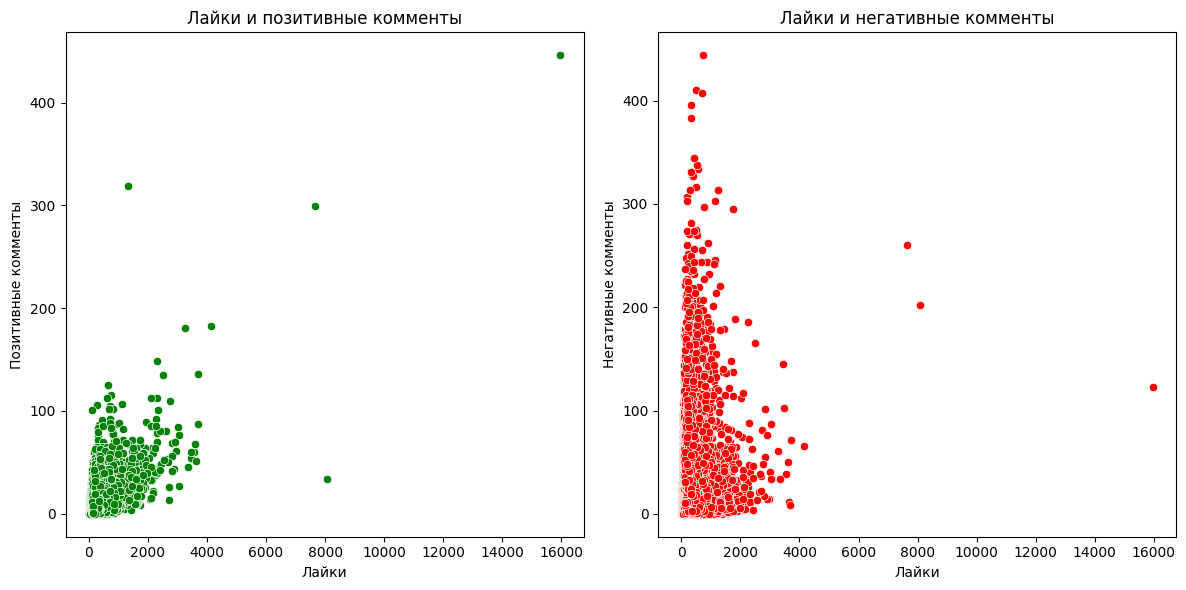

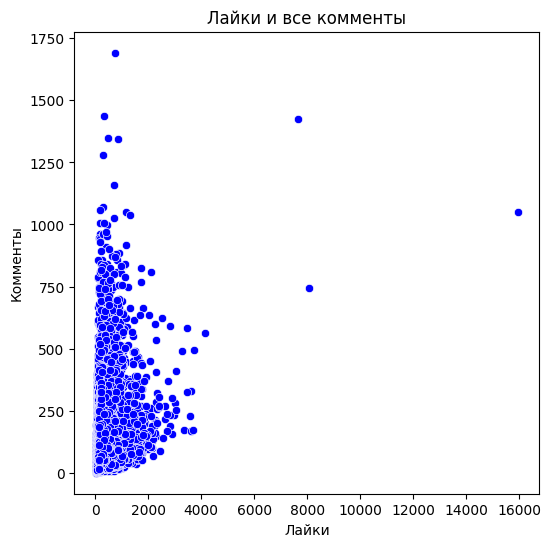

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_vk, x='likes', y='positive_comments_count', color='green')
plt.title('Лайки и позитивные комменты')
plt.xlabel('Лайки')
plt.ylabel('Позитивные комменты')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_vk, x='likes', y='negative_comments_count', color='red')
plt.title('Лайки и негативные комменты')
plt.xlabel('Лайки')
plt.ylabel('Негативные комменты')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_vk, x='likes', y='total_comments', color='blue')
plt.title('Лайки и все комменты')
plt.xlabel('Лайки')
plt.ylabel('Комменты')
plt.show()

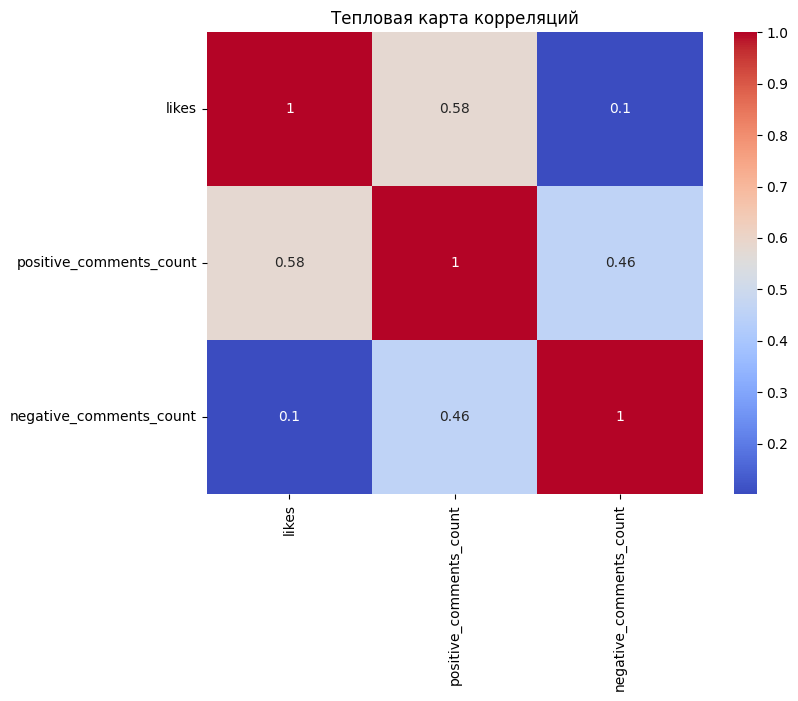

In [ ]:
correlation_matrix = df_vk[['likes', 'positive_comments_count', 'negative_comments_count']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляций')
plt.show()

Новости с большим количеством лайков действительно получают больше позитивных комментариев по сравнению с маленьким количеством. К тому же, начиная с определенного количества лайков, количество комментариев растет.

__[0.2]__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаen, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [ ]:
import math

def formula(u, d):
    a = 1 + u
    b = 1 + d

    frac_l = a / (a + b)
    const = -1.65
    frac_r = (a * b) / (((a + b) ** 2) * (a + b + 1))

    return frac_l + const * math.sqrt(frac_r)

In [ ]:
df_vk["quant005"] = df_vk.apply(lambda x: formula(x['positive_comments_count'], x['negative_comments_count']), axis=1)
top_news = df_vk.sort_values(by='quant005').tail(10)

for _, txt in top_news["title"].items():
    print(txt)

Бондарь и Минибаев победили в синхронных прыжках в воду с вышки на ЧЕ
Российские дзюдоисты победили в медальном зачете этапа Гран-при в Марокко
Тарасова и Морозов победили в соревнованиях спортивных пар на этапе Гран-при в Москве
Кузнецов и Захаров победили в синхронных прыжках с трамплина на ЧЕ
Россиянки выиграли золото по биатлону в эстафете на этапе Кубка мира
Российская шахматистка Александра Костенюк стала чемпионкой Европы по блицу
Россиянин Иван Бессонов победил в конкурсе "классического Евровидения"
Российские фигуристы Боброва и Соловьев победили в танцах на льду на турнире в Шанхае
Российские хоккеисты обыграли Канаду на молодежном чемпионате мира
Сборная России выиграла командный турнир на чемпионате мира по художественной гимнастике 


Построили? Срочно пришлите свою любимую позитивную  новость в общий чат!!!

Топ негативных новостей строить не будем. Вокруг итак слишком много негатива 😻😻😻

__[0.2]__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__

In [ ]:
import gdown

gdown.download("https://drive.google.com/uc?id=1Ve3bkCtJrrbrrhV-EGo9jFfr5ryesDI3")

Downloading...
From: https://drive.google.com/uc?id=1Ve3bkCtJrrbrrhV-EGo9jFfr5ryesDI3
To: /content/final_predictions.csv
100%|██████████| 63.4M/63.4M [00:00<00:00, 224MB/s]


'final_predictions.csv'

In [ ]:
final_predictions = pd.read_csv("final_predictions.csv")

In [ ]:
final_predictions.rename(columns={"post_id": "id"}, inplace=True)

In [ ]:
final_predictions.rename(columns={str(k): v for k, v in idx2tag.items()}, inplace=True)

In [ ]:
final_predictions.drop(columns=[final_predictions.columns[0]], inplace=True)

In [ ]:
merged_df = final_predictions.merge(df_vk, on='id')

In [ ]:
tagged = merged_df[final_predictions.columns[:-1]].multiply(merged_df['quant005'], axis="index")

tag_means = tagged.sum() / (merged_df[final_predictions.columns[:-1]] == 1).sum()

tag_scores_df = tag_means.reset_index()
tag_scores_df.columns = ['Tag', 'Average_Score']


top_positive_tags = tag_scores_df.sort_values(by='Average_Score', ascending=False).head(10)
top_negative_tags = tag_scores_df.sort_values(by='Average_Score').head(10)

print("Топ позитивных тегов:\n", top_positive_tags)
print("\nТоп негативных тегов:\n", top_negative_tags)

Топ позитивных тегов:
                                             Tag  Average_Score
1160                             дмитрий хохлов       0.186260
556                            йенс столтенберг       0.186155
146   приостановка участия россии в работе пасе       0.184973
661                        александр лаврентьев       0.184387
915                                 илья геркус       0.184191
459                                        дума       0.183928
361                                    в россии       0.183603
653                  сборная россии по биатлону       0.183373
586                                        снос       0.183271
1375                          виктор ганчаренко       0.182957

Топ негативных тегов:
                                        Tag  Average_Score
1207         ситуация с беженцами в европе       0.158818
184             фестиваль "спасская башня"       0.159151
968                       средиземное море       0.160137
1431                гватемал

__[0.2 бонусных]__ Проанализируйте, как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью)? Значима ли эта взаимосвязь? Если вам для проверки этого хочется построить линейную регрессию, не сдерживайтесь.

In [53]:
coeffs = {'positive': 0, 'neutral': 0.5, 'negative': 1}
df_comments_final["neg"] = df_comments_final.apply(lambda x: coeffs[x['label']] * x['score'], axis=1)
df_comments_final

,id,post_id,datetime,text,likes,label,score,neg
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0,neutral,0.912246,0.456123
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0,neutral,0.879370,0.439685
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0,positive,0.676261,0.000000
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0,neutral,0.925939,0.462970
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0,neutral,0.866223,0.433111
...,...,...,...,...,...,...,...,...
2612624,17991829,17976037.0,2017-09-30 10:27:11,"Сергей, я про простых американцев, которые слу...",0.0,neutral,0.649754,0.324877
2612625,17992004,17976037.0,2017-09-30 10:49:21,"[id415883695|Евгений], у них довольствие и они...",0.0,negative,0.697936,0.697936
2612626,17992058,17976037.0,2017-09-30 10:56:29,"[id142882974|Сергей], ну Кадафи и Хусейныча он...",0.0,negative,0.623313,0.623313
2612627,17992487,17976037.0,2017-09-30 11:56:03,"[id142882974|Сергей], для этого существует физ...",0.0,neutral,0.873600,0.436800


In [54]:
agg = df_comments_final.groupby('post_id').agg(
    thread_length=pd.NamedAgg(column='id', aggfunc='count'),
    average_negativity=pd.NamedAgg(column='neg', aggfunc='mean')
).reset_index()
agg.head(10)

,post_id,thread_length,average_negativity
0,17976037.0,238,0.429778
1,17976198.0,51,0.423524
2,17976601.0,67,0.425588
3,17976766.0,48,0.401234
4,17976905.0,112,0.453227
5,17977107.0,51,0.426290
6,17977276.0,63,0.397170
7,17977614.0,75,0.429499
8,17978061.0,52,0.480064
9,17978263.0,131,0.413051


In [58]:
agg.rename(columns={"post_id": "id"}, inplace=True)

In [63]:
posts = df_vk.merge(agg, on="id", how='left')
posts.head(10)

,id,href,datetime,title,likes,comments,snippet,title_clean,snippet_clean,target_tags,positive_comments_count,negative_comments_count,total_comments,thread_length,average_negativity
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN,в днр заявили о задержании диверсантов причаст...,#UNK#,[0],2.0,10.0,47.0,47.0,0.446893
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN,житель урала заминировал тц изза снятия сотов...,#UNK#,[0],3.0,11.0,42.0,42.0,0.409225
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN,в черном море нашли потерянный флот гитлера,#UNK#,[0],3.0,4.0,22.0,22.0,0.364373
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN,в сша освободили задержанную российскую актрис...,#UNK#,[0],2.0,10.0,40.0,40.0,0.420360
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN,толкнувший скабееву депутат рады заявил о гроз...,#UNK#,[0],10.0,37.0,140.0,140.0,0.442977
5,24005669,/20190201/1550256715.html,2019-02-01 20:43:42,Жительница Белгорода перевела мошенникам 43 ми...,79,155,NaN,жительница белгорода перевела мошенникам 43 ми...,#UNK#,[0],11.0,43.0,157.0,157.0,0.439263
6,24005531,/20190201/1550266666.html,2019-02-01 20:20:22,"В Подмосковье врачи спасли руку пациента, пере...",155,47,NaN,в подмосковье врачи спасли руку пациента перес...,#UNK#,[0],8.0,8.0,44.0,44.0,0.358515
7,24005400,/20190201/1550280682.html,2019-02-01 19:53:43,Трамп хочет заключить новый договор на смену Д...,45,72,NaN,трамп хочет заключить новый договор на смену д...,#UNK#,[0],4.0,16.0,70.0,70.0,0.417624
8,24005074,/20190201/1550257362.html,2019-02-01 19:02:05,Лукашенко поручил убрать из школьных программ ...,144,151,NaN,лукашенко поручил убрать из школьных программ ...,#UNK#,[0],8.0,20.0,151.0,151.0,0.420746
9,24004899,https://rsport.ria.ru/20190201/1550277848.html,2019-02-01 18:35:07,Сборная России вышла в финал чемпионата мира п...,407,55,NaN,сборная россии вышла в финал чемпионата мира п...,#UNK#,[0],8.0,1.0,54.0,54.0,0.322097


In [61]:
posts.dropna(subset=['thread_length', 'average_negativity'], inplace=True)

In [62]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()
X = posts[['thread_length']]
y = posts['average_negativity']
regr.fit(X, y)

print(regr.score(X, y))

0.06373058077404381


R^2 скор модели близок к нулю - значит, мы не выявили корреляцию.